In [16]:
####################################################
#importing libraries
####################################################
import torch 
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi']= 150
import seaborn as sns
sns.set(style="whitegrid")

In [17]:
####################################################
#hyperparameters
####################################################

batch_size = 64

seq_len = 30

input_size = 7
lstm_hidden_size = 120
linear_hidden_size_1 = 241
linear_hidden_size_2 = 52
output_size = 6

dropout_1 = 0.480002
dropout_2 = 0.260193

learning_rate = 0.003177
num_epochs = 200

seed = 7123515
#seed = np.random.randint(10000000, size=1).item() #random seed
print(seed)
load_model = True

7123515


In [18]:
####################################################
#dataset import and sequencing
####################################################

#data importing
df = pd.read_excel('ALL VAR cleaned.xlsx')
df.Date = pd.to_datetime(df.Date, format = '%m/%d/%Y')
df = df.set_index('Date')

#data scaling
df_scaled = (df - df.mean())/ df.std()
#print(df_scaled.head())

#storing mean and std
df_np_mean = df.mean().to_numpy()
df_np_std = df.std().to_numpy()

#dropping date column
df_scaled.reset_index(inplace = True)
df_scaled = df_scaled.drop('Date', 1)

#creating sequences
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix +1 >= len(sequences): break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, 0:7], sequences[end_ix + 1, 7:14]
        X.append(seq_x)
        y.append(seq_y)
    return X, y

array = df_scaled.iloc[:, :].values
print ('shape of the datset array: {}'.format(array.shape))
X, y = split_sequences(array, seq_len)
X_array = np.array(X, dtype = np.float32)
y_array = np.array(y)
print('sequenced X array shape: {}'.format(X_array.shape))
print('y array shape: {}'.format(y_array.shape))
print('null values in dataset?: {}'.format(df_scaled.isnull().values.any()))

shape of the datset array: (2184, 13)
sequenced X array shape: (2153, 30, 7)
y array shape: (2153, 6)
null values in dataset?: False


In [19]:
####################################################
#output mask preparation
####################################################


#import output masked data
df_mask = pd.read_excel('COMBINED CAMS MASK.xlsx')
#print(df_mask.head())

mask_array = df_mask.iloc[:, :].values
#print(mask_array.shape)

#sequencing
def mask_sequence(sequence, n_steps):
    y = list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_iy = i + n_steps
        # check if we are beyond the dataset
        if end_iy + 1 >= len(sequence): break
        # gather input and output parts of the pattern
        seq_y = sequence[end_iy + 1, 0:6]
        y.append(seq_y)
    return y

mask_list = mask_sequence(mask_array, seq_len)
mask_array = np.array(mask_list)
print('masked output array shape: {}'.format(mask_array.shape))

masked output array shape: (2153, 6)


In [20]:
####################################################
#creating dataset and subsets
####################################################

#creating dataset
class AirMeteoroDataset(Dataset):
    def __init__(self):
        self.len = X_array.shape[0]
        self.X_data = torch.from_numpy(X_array)
        self.y_data = torch.from_numpy(y_array)
        self.y_mask = torch.from_numpy(mask_array)

    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index], self.y_mask[index], index

    def __len__(self):
        return self.len
    
dataset = AirMeteoroDataset()
train_size = round(len(X_array) * 0.7)
val_size = round((len(X_array) - train_size)/2)
test_size = len(X_array) - train_size - val_size
train_set, val_set, test_set = torch.utils.data.random_split(dataset,
                                                             [train_size, val_size, test_size], 
                                                             generator = torch.Generator().manual_seed(seed))

In [32]:
####################################################
#making mini-batches using dataloader
####################################################

train_loader = DataLoader(dataset = train_set,
                          batch_size = batch_size,
                          drop_last = True,
                          shuffle = True)

val_loader = DataLoader(dataset = val_set,
                          batch_size = batch_size,
                          drop_last = True,
                          shuffle = True)

test_loader = DataLoader(dataset = test_set,
                          batch_size = batch_size,
                          drop_last = True,
                          shuffle = False)

In [33]:
####################################################
#model building
####################################################

class Model(nn.Module):
    def __init__(self, 
                 input_size, 
                 lstm_hidden_size, 
                 linear_hidden_size_1, 
                 linear_hidden_size_2, 
                 output_size, 
                 dropout_1,
                 dropout_2):
        super(Model, self).__init__()
        self.input_size = input_size
        self.lstm_hidden_size = lstm_hidden_size
        self.linear_hidden_size_1 = linear_hidden_size_1
        self.linear_hidden_size_2 = linear_hidden_size_2
        self.output_size = output_size
        
        self.batchnorm1 = nn.BatchNorm1d(num_features = linear_hidden_size_1)
        self.batchnorm2 = nn.BatchNorm1d(num_features = linear_hidden_size_2)

        
        self.relu = nn.ReLU()
        
        self.dropout_1 = nn.Dropout(p = dropout_1)
        self.dropout_2 = nn.Dropout(p = dropout_2)
        
        self.lstm = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.lstm_hidden_size,
            batch_first = True)
        
        self.linear_1 = nn.Linear(self.lstm_hidden_size, self.linear_hidden_size_1)
        self.linear_2 = nn.Linear(self.linear_hidden_size_1, self.linear_hidden_size_2)
        self.linear_3 = nn.Linear(self.linear_hidden_size_2, self.output_size)
    
        
    def forward(self, sequences):
        lstm_out, _ = self.lstm(sequences)
        
        z1 = self.linear_1(lstm_out[:, -1, :])
        a1 = self.dropout_1(self.relu(self.batchnorm1(z1)))
        
        z2 = self.linear_2(a1)
        a2 = self.dropout_2(self.relu(self.batchnorm2(z2)))
        
        y_pred = self.linear_3(a2)
        return y_pred

In [34]:
####################################################
#custom loss function
####################################################

class modsmoothl1(nn.SmoothL1Loss):
    def __init__(self, size_average=None, reduce=None, reduction = 'none'):
        super(modsmoothl1, self).__init__(size_average, reduce, reduction)
        
    def forward(self, observed, predicted, mask):
        predicted_masked = mask*predicted
        loss = F.smooth_l1_loss(observed, predicted_masked, reduction=self.reduction)
        avg_loss = torch.sum(loss)/torch.sum(mask)
        return avg_loss

In [35]:
####################################################
#model initialization
####################################################
forecast_model = Model(input_size,
                   lstm_hidden_size,
                   linear_hidden_size_1,
                   linear_hidden_size_2,
                   output_size,
                   dropout_1,
                   dropout_2).cuda().float()

criterion = modsmoothl1()
optimizer = torch.optim.Adam(forecast_model.parameters(), lr = learning_rate)

In [36]:
####################################################
#saving and loading checkpoints
####################################################

def save_checkpoint(state, filename="LSTM Final model.pth.tar"):
    print("Saving checkpoint...")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer):
    print("Loading checkpoint...")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

In [37]:
####################################################
#model training and validation
####################################################

#model training
if load_model == False:
    all_train_loss = []
    all_val_loss = []


    for epoch in range(num_epochs):
        forecast_model.train()
        epoch_total_loss = 0.0

        for i, (X_data, y_data, y_mask, index) in enumerate(train_loader):    
            optimizer.zero_grad()

            X_data = X_data.cuda().float()
            y_data = y_data.cuda().float()
            y_mask = y_mask.cuda().float()

            y_pred = forecast_model(X_data)
            loss = criterion(y_data, y_pred, y_mask)

            loss.backward()
            optimizer.step()

            epoch_total_loss = epoch_total_loss + loss.item()

        epoch_avg_loss = epoch_total_loss/len(train_loader)

        if (epoch +1) % round(num_epochs/20) == 0:
            print (f'Train loss after Epoch [{epoch+1}/{num_epochs}]: {epoch_avg_loss:.6f}, Val loss: {epoch_avg_val_loss:.6f}')

        all_train_loss.append(epoch_avg_loss)


        forecast_model.eval()   
        with torch.no_grad():
            epoch_total_val_loss = 0.0
            for i, (X_val, y_val, y_mask_val, index) in enumerate(val_loader):
                X_val = X_val.cuda().float()
                y_val = y_val.cuda().float()
                y_mask_val = y_mask_val.cuda().float()        

                val_pred = forecast_model(X_val).cuda()
                val_loss = criterion(y_val, val_pred, y_mask_val)
                epoch_total_val_loss = epoch_total_val_loss + val_loss.item()


        epoch_avg_val_loss = epoch_total_val_loss/len(val_loader)
        all_val_loss.append(epoch_avg_val_loss)

In [38]:
####################################################
#saving test and validation losses
####################################################

if load_model == False:
    print("Saving losses...")
    df_train_loss = pd.DataFrame(all_train_loss, columns = ["Values"])
    df_train_loss.to_csv('train_loss.csv', index = False)

    df_val_loss = pd.DataFrame(all_val_loss, columns = ["Values"])
    df_val_loss.to_csv('Validation_loss.csv', index = False)
    
    checkpoint = {"state_dict": forecast_model.state_dict(), "optimizer": optimizer.state_dict()}
    save_checkpoint(checkpoint)

In [39]:
####################################################
#loading test and validation losses
####################################################

if load_model == True:
    import itertools
    print("Loading losses...")
    df_train_loss = pd.read_csv('Train_loss.csv')
    all_train_loss_2d = df_train_loss.values.tolist()
    all_train_loss = list(itertools.chain.from_iterable(all_train_loss_2d))

    df_val_loss = pd.read_csv('Validation_loss.csv')
    all_val_loss_2d = df_val_loss.values.tolist()
    all_val_loss = list(itertools.chain.from_iterable(all_val_loss_2d))
    
    load_checkpoint(torch.load("LSTM Final model.pth.tar"), forecast_model, optimizer)

Loading losses...
Loading checkpoint...


Text(0, 0.5, 'Training Loss')

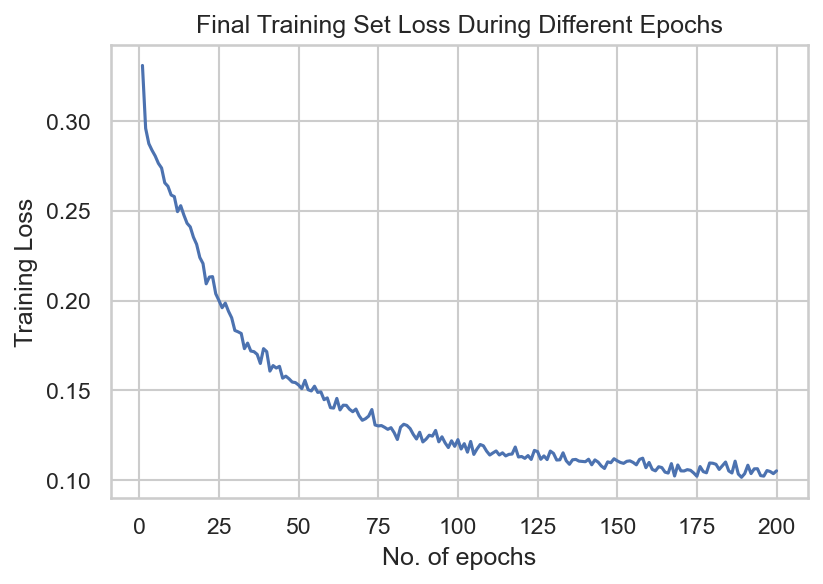

In [40]:
####################################################
#plot training loss
####################################################

plt.plot(list(range(1, num_epochs + 1)), all_train_loss, label = 'Train Loss')
plt.title('Final Training Set Loss During Different Epochs')
plt.xlabel('No. of epochs')
plt.ylabel('Training Loss')

In [58]:
####################################################
#test loss
####################################################

all_index = torch.empty(0).cuda()
all_obs = torch.empty(0, output_size).cuda()
all_pred = torch.empty(0, output_size).cuda()
forecast_model.eval()
with torch.no_grad():
    total_test_loss = 0.0
    for i, (X_test, y_test, y_mask_test, index) in enumerate(test_loader):
        X_test = X_test.cuda().float()
        y_test = y_test.cuda().float()
        y_mask_test = y_mask_test.cuda().float()
        index = index.cuda().float()
        
        test_pred = forecast_model(X_test).cuda()
        test_loss = criterion(y_test, test_pred, y_mask_test)
        total_test_loss = total_test_loss + test_loss.item()
        
        all_index = torch.cat((all_index, index),0)
        all_obs = torch.cat((all_obs, y_test), 0)
        all_pred = torch.cat((all_pred, test_pred), 0)
        
        
    avg_test_loss = total_test_loss/len(test_loader)
    print(avg_test_loss)

0.13506495207548141


In [31]:
####################################################
#output preparation
####################################################
pred_out_np = all_pred.cpu().numpy()
obs_out_np = all_obs.cpu().numpy()
df_out_mean = df_np_mean[7:13]
df_out_std = df_np_std[7:13]
final_pred = pred_out_np * df_out_std + df_out_mean
final_observed = obs_out_np * df_out_std + df_out_mean
all_index = all_index.cpu().numpy()

In [ ]:
####################################################
#obs output export
####################################################

out_obs_data = pd.DataFrame({'SO2  ': final_observed[:, 0],
                         'NO2': final_observed[:, 1],
                         'CO': final_observed[:, 2],
                         'O3': final_observed[:, 3],
                         'PM2.5': final_observed[:, 4], 
                         'PM10': final_observed[:, 5],
                         'Index': all_index})
filename_obs = 'LSTM plot_obs.xlsx'
out_obs_data.to_excel(filename_obs, index=True)

In [ ]:
####################################################
#pred output export
####################################################

out_pred_data = pd.DataFrame({'SO2  ': final_pred[:, 0],
                         'NO2': final_pred[:, 1],
                         'CO': final_pred[:, 2],
                         'O3': final_pred[:, 3],
                         'PM2.5': final_pred[:, 4], 
                         'PM10': final_pred[:, 5],
                         'Index': all_index})
filename_pred = 'LSTM plot_pred.xlsx'
out_pred_data.to_excel(filename_pred, index=True)

In [ ]:
####################################################
fixed
####################################################

df_obs = pd.read_excel("LSTM plot_obs.xlsx")
df_obs[df_obs < 0.0001] = 0
df_obs.to_excel("LSTM plot_obs_final.xlsx")

df_pred = pd.read_excel("LSTM plot_pred.xlsx")
df_pred[df_pred < 0.0001] = 0
df_pred.to_excel("LSTM plot_pred_final.xlsx")